In [29]:
# GPU を無効化する
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from datetime import datetime
from decimal import Decimal, ROUND_HALF_UP
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

input_dir = '/home/maeda/data/geosciAI24/TC_data_GeoSciAI2024/'

(64, 64)


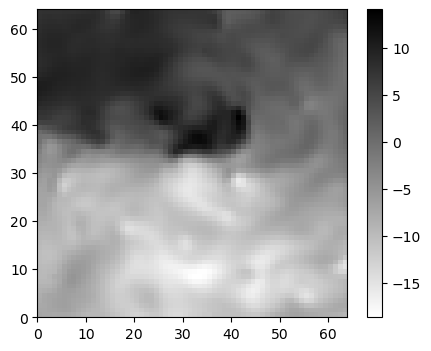

[[-7.1411133 -7.305908  -7.397461  ... -8.459473  -8.734131  -9.100342 ]
 [-7.397461  -7.2875977 -7.0861816 ... -7.7819824 -7.8552246 -8.093262 ]
 [-7.6171875 -7.470703  -7.0495605 ... -7.8918457 -7.5805664 -7.562256 ]
 ...
 [ 8.03833    8.294678   8.404541  ...  4.925537   5.1086426  5.456543 ]
 [ 7.836914   8.03833    8.111572  ...  5.3466797  5.657959   6.060791 ]
 [ 7.6171875  7.763672   7.800293  ...  5.5114746  5.8776855  6.2438965]]


In [5]:
x = np.load('/home/maeda/data/geosciAI24/TC_data_GeoSciAI2024/field_data/1979/U850/u850_1979010106_055_011s.npz')
print(x['data'].shape)

plt.figure(figsize=(5,4))
fig = plt.pcolormesh(x['data'], cmap='gray_r', )
cbar = plt.colorbar(fig)
plt.show()
print(x['data'])

In [3]:
# glob : 指定したパターンに一致するファイルパスのリストを取得
files = glob.glob(input_dir + 'track_data/197901*')
path  = []
for csvfile in files:
    df = pd.read_csv(csvfile)
    tsteps = df.shape[0] 
    print(df.iloc[0])
    print(tsteps)
    for index, row in df.iterrows():
        ymdh = datetime.strptime(row.iloc[0], "%HZ%d%b%Y").strftime('%Y%m%d%H')
        
        lon = row.iloc[1]
        lat = row.iloc[2]
        ws = row.iloc[3]
        pmin = row.iloc[4]
        time = row.iloc[5]
        stage = row.iloc[6]
        if lat<0:
            ns = "s"
        else:
            ns = "n"

        filename = f"{ymdh}_{(round(lon)):03}_{(round(abs(lat))):03}{ns}.npz"
        print(filename)
        path.append(filename)

Time [HHzDDMMMYYYY]                             12Z28JAN1979
Longitude [degree]                                   129.985
Latitude [degree]                                    -15.412
Maximum 10m wind speed [m/s]                            10.3
Central pressure [hPa]                                999.74
Elapsed time based on genesis [hour]                     -36
Life-stage label (pre-TC:0, TC:1, post-TC:2)               0
Name: 0, dtype: object
23
1979012812_130_015s.npz
1979012818_129_016s.npz
1979012900_129_016s.npz
1979012906_127_018s.npz
1979012912_126_018s.npz
1979012918_124_018s.npz
1979013000_123_019s.npz
1979013006_122_020s.npz
1979013012_122_021s.npz
1979013018_120_021s.npz
1979013100_119_022s.npz
1979013106_119_023s.npz
1979013112_119_023s.npz
1979013118_118_024s.npz
1979020100_118_024s.npz
1979020106_118_025s.npz
1979020112_118_026s.npz
1979020118_118_027s.npz
1979020200_119_028s.npz
1979020206_120_029s.npz
1979020212_121_029s.npz
1979020218_121_029s.npz
1979020300_121_030s

In [30]:
# 各変数ごとのファイルリストを取得
def get_file_list(input_dir, start_year, end_year, field, FIELD):
    path  = []
    trackfiles = []
    data = []
    
    for i in range(start_year, end_year+1):
        trackfiles += glob.glob(input_dir + f'track_data/{i}*.csv')
    
    for csvfile in trackfiles:
        df = pd.read_csv(csvfile)
        tsteps = df.shape[0] 
        print(df.iloc[0])
        print(tsteps)
        for index, row in df.iterrows():
            ymdh = datetime.strptime(row.iloc[0], "%HZ%d%b%Y").strftime('%Y%m%d%H')
            
            lon = row.iloc[1]
            lat = row.iloc[2]
            ws = row.iloc[3]
            pmin = row.iloc[4]
            time = row.iloc[5]
            stage = row.iloc[6]
            if lat<0:
                ns = "s"
            else:
                ns = "n"
            # 四捨五入を１０進数で正確に行う
            round_lon = Decimal(lon).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
            round_lat = Decimal(lat).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
            if round_lon == 360:
                round_lon = 0
            filename = f"{field}_{ymdh}_{(round_lon):03}_{(abs(round_lat)):03}{ns}.npz"
            print(filename)
            data_i = np.load(input_dir + f'field_data/{ymdh[:4]}/{FIELD}/{filename}')
            path.append(filename)
            data.append(data_i['data'])
    return path, data

In [ ]:
def get_data(input_dir, path, start_year, end_year, FIELD):
    data = []
    for file in path:
        x = np.load(input_dir + f'field_data//{FIELD}/{file}')
        data.append(x['data'])
    return data

#### 3ステップ＊７変数

In [30]:
def get_input_ans(start_year, end_year, input_dir, n_input = 3):
    trackfiles = []
    field = ['olr', 'qv600', 'slp', 'u200', 'u850', 'v200', 'v850']
    FIELD = ['OLR', 'QV600', 'SLP', 'U200', 'U850', 'V200', 'V850']
    #field = ['olr']
    #FIELD = ['OLR']
    for i in range(start_year, end_year+1):
        trackfiles += glob.glob(input_dir + f'track_data/{i}*.csv')

    input=[]
    ans =[]
    for file in trackfiles:
        df = pd.read_csv(file)
        col = df.columns
        colname = col[6] #TCフラグ
        tc_df = df[df[colname] == 1] #TCフラグが１のところだけ抽出
        index = tc_df.index
        start_index = max([index[0], 2]) #発生時に２ステップ前のデータを使いたいが、ない場合は諦める。
        end_index = min([index[-1], df.shape[0]-5]) #最後のTCフラグ1の時点から24時間後（4ステップ先）の予測をしたいがデータがないかもしれない。

        time = np.array(df.iloc[start_index-2:end_index+4+1, 0])
        lon  = np.array(df.iloc[start_index-2:end_index+4+1, 1])
        lat  = np.array(df.iloc[start_index-2:end_index+4+1, 2])
        wind = np.array(df.iloc[start_index-2:end_index+4+1, 3])
        tsteps = wind.shape[0] - 2 - 4
        
        # 予測対象の画像データを取得
        for ii in range(tsteps):
            x = np.zeros((64, 64, len(field)*3), dtype=np.float32)
            for kk in range(3):
                if lat[ii+kk]<0:
                    ns = "s"
                else:
                    ns = "n"
                # 四捨五入を１０進数で正確に行う
                round_lon = Decimal(lon[ii+kk]).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
                round_lat = Decimal(lat[ii+kk]).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
                if round_lon == 360:
                    round_lon = 0
                ymdh = datetime.strptime(time[ii+kk], "%HZ%d%b%Y").strftime('%Y%m%d%H')
                # 対応するデータの読み込み
                for jj in range(len(field)):
                    #if jj == 3:   # SST は daily data なので時間を丸めて処理
                    #    ymdh = datetime.strptime(time[ii], "%HZ%d%b%Y").strftime('%Y%m%d00')
                    filename = f"{field[jj]}_{ymdh}_{(round_lon):03}_{(abs(round_lat)):03}{ns}.npz"
                    xi = np.load(input_dir + f'field_data/{ymdh[:4]}/{FIELD[jj]}/{filename}')
                    x[:,:,3*jj+kk] = xi['data']
                    
                input.append(x)
                ans.append(wind[ii+n_input+4-1])
            
    return np.array(input), np.array(ans)

In [32]:
input_train, ans_train = get_input_ans(1979, 1980, input_dir)
print(input_train.shape)
print(ans_train.shape)

(14295, 64, 64, 21)
(14295,)


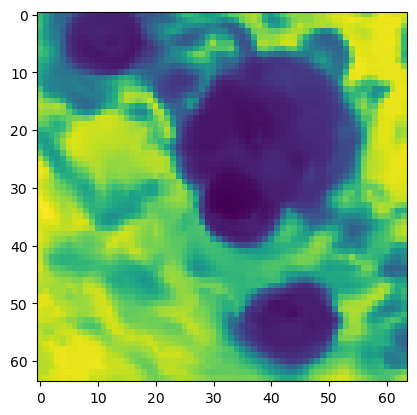

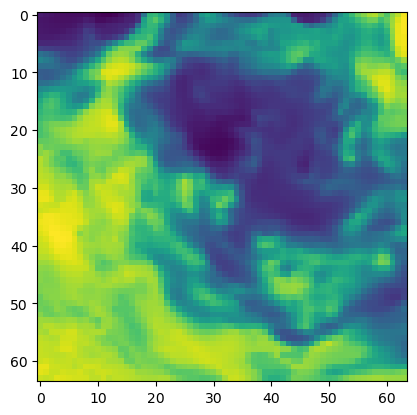

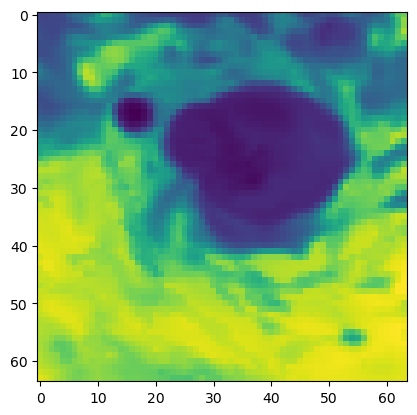

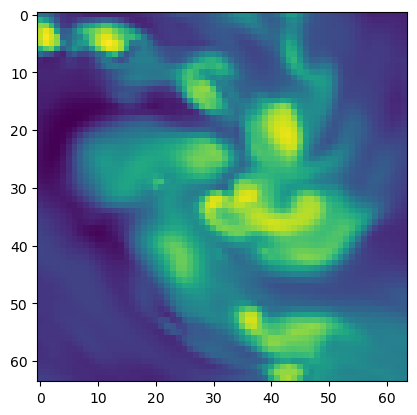

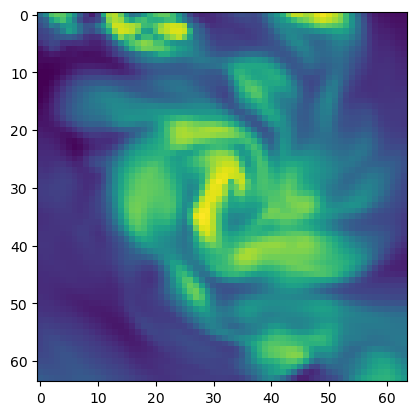

In [37]:
for i in range(5):
    plt.imshow(input_train[0,:,:,i])
    plt.show()

#### １変数

In [ ]:
def get_input_ans(start_year, end_year, input_dir, n_input = 1):
    trackfiles = []
    field = ['olr', 'qv600', 'slp', 'u200', 'u850', 'v200', 'v850']
    FIELD = ['OLR', 'QV600', 'SLP', 'U200', 'U850', 'V200', 'V850']
    #field = ['olr']
    #FIELD = ['OLR']
    for i in range(start_year, end_year+1):
        trackfiles += glob.glob(input_dir + f'track_data/{i}*.csv')

    input=[]
    ans =[]
    for file in trackfiles:
        df = pd.read_csv(file)
        col = df.columns
        colname = col[6] #TCフラグ
        tc_df = df[df[colname] == 1] #TCフラグが１のところだけ抽出
        index = tc_df.index
        start_index = max([index[0], 2]) #発生時に２ステップ前のデータを使いたいが、ない場合は諦める。
        end_index = min([index[-1], df.shape[0]-5]) #最後のTCフラグ1の時点から24時間後（4ステップ先）の予測をしたいがデータがないかもしれない。

        time = np.array(df.iloc[start_index-2:end_index+4+1, 0])
        lon  = np.array(df.iloc[start_index-2:end_index+4+1, 1])
        lat  = np.array(df.iloc[start_index-2:end_index+4+1, 2])
        wind = np.array(df.iloc[start_index-2:end_index+4+1, 3])
        tsteps = wind.shape[0] - 2 - 4
        
        # 予測対象の画像データを取得
        for ii in range(tsteps):
            x = np.zeros((64, 64, len(field)), dtype=np.float32)
            if lat[ii]<0:
                ns = "s"
            else:
                ns = "n"
            # 四捨五入を１０進数で正確に行う
            round_lon = Decimal(lon[ii]).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
            round_lat = Decimal(lat[ii]).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
            if round_lon == 360:
                round_lon = 0
            ymdh = datetime.strptime(time[ii], "%HZ%d%b%Y").strftime('%Y%m%d%H')
            # 対応するデータの読み込み
            for jj in range(len(field)):
                #if jj == 3:   # SST は daily data なので時間を丸めて処理
                #    ymdh = datetime.strptime(time[ii], "%HZ%d%b%Y").strftime('%Y%m%d00')
                filename = f"{field[jj]}_{ymdh}_{(round_lon):03}_{(abs(round_lat)):03}{ns}.npz"
                xi = np.load(input_dir + f'field_data/{ymdh[:4]}/{FIELD[jj]}/{filename}')
                x[:,:,jj] = xi['data']
                
            input.append(x)
            ans.append(wind[ii+n_input+4-1])
            
    return np.array(input), np.array(ans)

#### 過去データ

In [77]:
def get_input_ans(start_year, end_year, n_input = 3):
    trackfiles = []
    field = ['olr', 'qv600', 'slp', 'sst', 'u200', 'u850', 'v200', 'v850']
    FIELD = ['OLR', 'QV600', 'SLP', 'SST', 'U200', 'U850', 'V200', 'V850']
    for i in range(start_year, end_year+1):
        trackfiles += glob.glob(input_dir + f'track_data/{i}*.csv')

    input=[]
    ans =[]
    for file in trackfiles:
        df = pd.read_csv(file)
        col = df.columns
        colname = col[6] #TCフラグ
        tc_df = df[df[colname] == 1] #TCフラグが１のところだけ抽出
        index = tc_df.index
        start_index = max([index[0], 2]) #発生時に２ステップ前のデータを使いたいが、ない場合は諦める。
        end_index = min([index[-1], df.shape[0]-5]) #最後のTCフラグ1の時点から24時間後（4ステップ先）の予測をしたいがデータがないかもしれない。

        time = np.array(df.iloc[start_index-2:end_index+4+1, 0])
        lon  = np.array(df.iloc[start_index-2:end_index+4+1, 1])
        lat  = np.array(df.iloc[start_index-2:end_index+4+1, 2])
        wind = np.array(df.iloc[start_index-2:end_index+4+1, 3])
        tsteps = wind.shape[0] - 2 - 4
        # initial sst data 
        if time[0][:2] == '06':
            ymdh_sst = datetime.strptime(df.iloc[start_index-5, 0], "%HZ%d%b%Y").strftime('%Y%m%d00')
            lon_sst  = df.iloc[start_index-5, 1]
            lat_sst  = df.iloc[start_index-5, 2]
        elif time[0][:2] == '12':
            ymdh_sst = datetime.strptime(df.iloc[start_index-4, 0], "%HZ%d%b%Y").strftime('%Y%m%d00')
            lon_sst  = df.iloc[start_index-4, 1]
            lat_sst  = df.iloc[start_index-4, 2]
        elif time[0][:2] == '18':
            ymdh_sst = datetime.strptime(df.iloc[start_index-3, 0], "%HZ%d%b%Y").strftime('%Y%m%d00')
            lon_sst  = df.iloc[start_index-3, 1]
            lat_sst  = df.iloc[start_index-3, 2]   
        if lat_sst<0:
            ns_sst = "s"
        else:
            ns_sst = "n"
        print(ymdh_sst,file)
        # 予測対象の画像データを取得
        for ii in range(tsteps):
            x = np.zeros((64, 64, len(field)), dtype=np.float32)
            if lat[ii]<0:
                ns = "s"
            else:
                ns = "n"
            # 四捨五入を１０進数で正確に行う
            round_lon = Decimal(lon[ii]).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
            round_lat = Decimal(lat[ii]).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
            if round_lon == 360:
                round_lon = 0
            ymdh = datetime.strptime(time[ii], "%HZ%d%b%Y").strftime('%Y%m%d%H')
            if ymdh[:-2] == '00':   # SST は daily data なので00時の位置データで読み込む
                ymdh_sst = datetime.strptime(time[ii], "%HZ%d%b%Y").strftime('%Y%m%d00')
                lon_sst = lon[ii]
                lat_sst = lat[ii]
                if lat_sst<0:
                    ns_sst = "s"
                else:
                    ns_sst = "n"
                if round_lon_sst == 360:
                    round_lon_sst = 0
            # 対応するデータの読み込み
            for jj in range(len(field)):
                if jj == 3:   # SST の読み込み
                    round_lon_sst = Decimal(lon_sst).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
                    round_lat_sst = Decimal(lat_sst).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
                    filename = f"{field[jj]}_{ymdh_sst}_{(round_lon_sst):03}_{(abs(round_lat_sst)):03}{ns_sst}.npz"
                else:
                    filename = f"{field[jj]}_{ymdh}_{(round_lon):03}_{(abs(round_lat)):03}{ns}.npz"
                xi = np.load(input_dir + f'field_data/{ymdh[:4]}/{FIELD[jj]}/{filename}')
                x[:,:,jj] = xi['data']
                
            input.append(x)
            ans.append(wind[ii+n_input+4-1])
    return np.array(input), np.array(ans)


In [78]:
input_train, ans_train = get_input_ans(1979, 1980)
input_valid, ans_valid = get_input_ans(1981, 1982)

print(input_train.shape)
print(ans_train.shape)
print(input_valid.shape)
print(ans_valid.shape)

1979110700 /home/maeda/data/geosciAI24/TC_data_GeoSciAI2024/track_data/1979110818_lon147_lat13n.csv


FileNotFoundError: [Errno 2] No such file or directory: '/home/maeda/data/geosciAI24/TC_data_GeoSciAI2024/field_data/1979/SST/sst_1979110700_151_010n.npz'

In [34]:
# nan データのカウント（変数別）
print(np.count_nonzero(np.isnan(input_train), axis=(1,2))[1000:2000,6])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0  66 123 123 121 110 103  82  65  28   7
  12  12   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

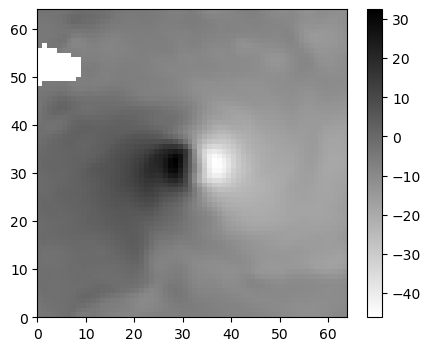

In [29]:
plt.figure(figsize=(5,4))
fig = plt.pcolormesh(input_train[232,:,:,6], cmap='gray_r', )
cbar = plt.colorbar(fig)
plt.show()

In [ ]:
# 標準化処理（欠損値はゼロとして計算）
input_std  = np.nanmean(input_train, axis=0)
input_mean = np.nanmean(input_train, axis=0)
ans_std    = np.nanmean(ans_train, axis=0)
ans_mean   = np.nanmean(ans_train, axis=0)

input_train_nm = (input_train - input_mean) / input_std
input_valid_nm = (input_valid - input_mean) / input_std
ans_train_nm   = (ans_train - ans_mean) / ans_std
ans_valid_nm   = (ans_valid - ans_mean) / ans_std

In [151]:
plt.figure(figsize=(5,4))
#for i in range(30):
#    fig = plt.pcolormesh(input_train[i,:,:,6], cmap='gray_r', )
#    cbar = plt.colorbar(fig)
#    plt.show()
print(input_mean[:,:10,6])

[[        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]


<Figure size 500x400 with 0 Axes>

In [98]:
# CNNモデルの構築
def cnn_model():
    model = Sequential()
    # 入力画像　25×144×3 ：(緯度方向の格子点数)×(軽度方向の格子点数)×(チャンネル数、OLRのラグ)
    model.add(Conv2D(32, (2, 2), padding='same', input_shape=(64, 64, 7), strides=(2,2)))   
    model.add(BatchNormalization())
    model.add(Activation('relu'))                                           
    model.add(Conv2D(64, (2, 2), padding='same', strides=(2,2)))                                        
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (2, 2), padding='same', strides=(2,2)))                           
    model.add(BatchNormalization())
    model.add(Conv2D(256, (2, 2), padding='same', strides=(2,2)))                           
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2)) 

    model.add(Flatten())  # 一次元の配列に変換                                # 1*16*64 -> 1024
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(64))
    model.add(Dense(1, activation='linear'))
    model.summary()
    return model

In [99]:
model = cnn_model()
model.compile(optimizer=Adam(), loss='mean_squared_error')
history = model.fit(input_train, ans_train, epochs=10, batch_size=128, validation_data=(input_valid, ans_valid))

/home/maeda/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 32)     │           928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 8, 8, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 4, 4, 256)      │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 708,065 (2.70 MB)

 Trainable params: 707,105 (2.70 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/10


2024-04-27 23:29:36.263323: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 546488320 exceeds 10% of free system memory.


38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: nan - val_loss: nan
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: nan - val_loss: nan
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: nan - val_loss: nan
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: nan - val_loss: nan
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: nan - val_loss: nan
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: nan - val_loss: nan
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: nan - val_loss: nan
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: nan - val_loss: nan
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: nan - val_loss: nan
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: nan - val_loss: nan


# 評価データの解析


In [17]:
result_dir = '/home/maeda/machine_learning/results/geosciAI24/predict/'

ans_mean, ans_std =  30.16864997588459, 8.726771295021933
scores = []
predicts = []

for j in range(10):
    result_file = result_dir + f"predict_test{(j):03}.npz"

    df = np.load(result_file)
    scores.append(df['score'])
    predicts.append(df['predict'][:,0])
scores = np.array(scores)
predicts = np.array(predicts)
ans = df['ans']

print(scores.shape, predicts.shape, ans.shape)


(10,) (10, 9304) (9304,)


In [25]:
print(predicts[0, :30])
ans_rcn = ans * ans_std + ans_mean

print(ans_rcn[:30])
rmse = np.mean((ans_rcn - predicts[0])**2)
rmse_ensemble = np.sqrt(np.mean((ans_rcn - predicts.mean(axis=0))**2))

print(rmse, rmse_ensemble)

[30.168282 29.585466 29.054499 33.124325 29.810534 30.782892 33.228676
 32.82563  31.489578 32.428482 33.19027  35.492073 33.63915  35.85839
 35.16812  33.267162 34.47306  32.670727 34.754147 34.00346  31.40122
 28.088884 28.38355  26.577156 27.29294  27.97984  27.60006  29.253143
 29.439722 30.010551]
[23.  25.3 31.5 28.5 30.  30.9 31.4 34.6 33.5 36.9 37.5 36.6 36.2 36.5
 36.9 36.3 35.  32.6 30.6 29.5 29.6 27.2 31.5 28.8 29.2 32.  27.7 22.6
 24.3 28.1]
29.578651517581775 5.318173358558477
